# Sky Matching 

<div class="alert-danger">Note: The notebook in this repository 'Initialization.ipynb' goes over many of the basic concepts such as the setup of the environment/package installation and should be read first if you are new to HST images, DrizzlePac, or Astroquery.</div>

## Introduction

When a user decided to mosaic several images it can be difficult to decide how to relate the background of one image to the others. AstroDrizzle has the ability to compute and then either subtract or equalize the background in input images in order to match the sky between those images. The function allows users to select the algorithm for the sky subtraction using the `skymethod` parameter. 

There are four methods available in sky matching: 'localmin', 'match', 'globalmin', 'globalmin+match'.

By applying `drizzlepac.sky.sky()`, or by applying the `skymethod` parameter in the call to `drizzlepac.astrodrizzle.AstroDrizzle()`, AstroDrizzle will update the keyword `MDRIZSKY` in the headers of the input files. 

The **recommended** use for images with sparse fields that have few astronomical sources is `skymethod = localmin` and for images with complicated backgrounds, such as nebulae and large host galaxies, `skymethod = match` is recommended.

For more information on the specifics of this function please refer to the documentation [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky).

Below, each of the four methods will be demonstrated using a single example dataset, and differences between the methods will be highlighted. 

In [1]:
# All imports needed through out this notebook are included at the beginning. 
import glob
from shutil import copyfile

from astropy.io import fits
from astroquery.mast import Observations
from ccdproc import ImageFileCollection
import matplotlib.pyplot as plt
import pandas as pd

import drizzlepac
from drizzlepac import tweakreg
from drizzlepac import tweakback



The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       config_testbed      imagefindpars           mapreg       
       photeq            pixreplace           pixtopix            pixtosky      
  refimagefindpars       resetbits          runastrodriz          skytopix      
     tweakback            tweakreg           updatenpol


## 1. Retrieve Observations using Astroquery

WFC3/IR observations of the Horsehead Nebula obtained in HST proposal 12812 (PI: Levay) will be used for this demonstration. The images have been processed by the HST WFC3 pipeline (calwf3), which includes bias subtraction, dark current correction, cosmic-ray rejection, and flatfielding.

The alignment specifics for this example are based on the example found [here](https://archive.stsci.edu/prepds/heritage/horsehead/readme_HLSP_v3.txt). We will provide explanation about the process as we go. 

The code used to retrieve the data from astroquery is below.

In [2]:
# Retrieve the observation information.
obs_table = Observations.query_criteria(proposal_id='12812', filters=["F160W"], project='HST')
obs_table.show_in_notebook()

# Figure out the downloadable products:
dataProductsByObservation = Observations.get_product_list(obs_table)
dataProductsByObservation.show_in_notebook()

# Download the flc.fits files: 
obsids = obs_table['obsid']

# Download the data - uncomment to download: 
Observations.download_products(obsids, mrp_only=False, productSubGroupDescription=['FLT', 'DRZ'])

Local Path,Status,Message,URL
str99,str8,object,object
./mastDownload/HLA/hst_12812_55_wfc3_ir_f160w/hst_12812_55_wfc3_ir_f160w_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_55_wfc3_ir_f160w_01/hst_12812_55_wfc3_ir_f160w_01_drz.fits,COMPLETE,None,None
./mastDownload/HLA/hst_12812_55_wfc3_ir_f160w_02/hst_12812_55_wfc3_ir_f160w_02_drz.fits,COMPLETE,None,None
./mastDownload/HST/hst_12812_55_wfc3_ir_f160w_ibxl55/hst_12812_55_wfc3_ir_f160w_ibxl55_drz.fits,COMPLETE,None,None
./mastDownload/HST/hst_12812_55_wfc3_ir_f160w_ibxl55f0/hst_12812_55_wfc3_ir_f160w_ibxl55f0_drz.fits,COMPLETE,None,None
./mastDownload/HST/hst_12812_55_wfc3_ir_f160w_ibxl55f0/hst_12812_55_wfc3_ir_f160w_ibxl55f0_flt.fits,COMPLETE,None,None
...,...,...,...
./mastDownload/HST/hst_12812_52_wfc3_ir_f160w_ibxl52k0/hst_12812_52_wfc3_ir_f160w_ibxl52k0_flt.fits,COMPLETE,None,None
./mastDownload/HST/hst_12812_52_wfc3_ir_f160w_ibxl52k5/hst_12812_52_wfc3_ir_f160w_ibxl52k5_drz.fits,COMPLETE,None,None


### Move files to the local directory 

In [3]:
flt_files = glob.glob('mastDownload/*/*/*flt.fits')

for file in flt_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_flt.fits"
    copyfile(file, dst)

drz_files = glob.glob('mastDownload/*/*/*drz.fits')

for file in drz_files:
    im = fits.open(file)
    rootname = im[0].header['ROOTNAME']
    im.close()
    dst = rootname + "_drz.fits"
    copyfile(file, dst)

### Inspect the image headers

In [4]:
collect_flt = ImageFileCollection('./', glob_include="*flt.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime", "postarg1", "postarg2"])
    
flt_table = collect_flt.summary
flt_table['exptime'].format = '7.1f'
flt_table['postarg1'].format = '7.2f'
flt_table['postarg2'].format = '7.2f'
flt_table

file,asn_id,detector,filter,exptime,postarg1,postarg2
str18,str9,str2,str5,float64,float64,float64
ibxl50clq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-113.11
ibxl50cqq_flt.fits,IBXL50030,IR,F160W,702.9,-123.74,-105.91
ibxl51eoq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-113.11
ibxl51etq_flt.fits,IBXL51030,IR,F160W,702.9,0.00,-105.91
ibxl52k0q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-113.11
ibxl52k5q_flt.fits,IBXL52030,IR,F160W,702.9,123.74,-105.91
...,...,...,...,...,...,...
ibxl55f5q_flt.fits,IBXL55030,IR,F160W,702.9,123.74,3.60
ibxl56huq_flt.fits,IBXL56030,IR,F160W,702.9,-123.74,105.91


In [5]:
collect_drz = ImageFileCollection('./', glob_include="*drz.fits", ext=0,
                                  keywords=["asn_id", "detector", "filter", "exptime"])
    
drz_table = collect_drz.summary
drz_table['exptime'].format = '7.1f'
drz_table

file,asn_id,detector,filter,exptime
str44,object,str2,str9,float64
hst_12812_50_wfc3_ir_f160w_ibxl50_drz.fits,--,IR,F160W,1405.9
hst_12812_50_wfc3_ir_f160w_ibxl50cl_drz.fits,IBXL50030,IR,F160W,702.9
hst_12812_50_wfc3_ir_f160w_ibxl50cq_drz.fits,IBXL50030,IR,F160W,702.9
hst_12812_50_wfc3_ir_f160w_run_1_drz.fits,IBXL50030,IR,F160W,1405.9
hst_12812_50_wfc3_ir_total_ibxl50_drz.fits,--,IR,detection,2511.8
hst_12812_51_wfc3_ir_f160w_ibxl51_drz.fits,--,IR,F160W,1405.9
...,...,...,...,...
ibxl56i2q_single_sci.fits_drz.fits,IBXL56030,IR,F160W,1.0
ibxl57030_drz.fits,IBXL57030,IR,F160W,1405.9


## 2. Align the visit-level drizzled data

Exposures obtained within a single HST visit tend to be aligned very well since they use the same guide stars. Thus, we will use TweakReg to align the DRZ files and then use TweakBack to propagate those solutions back to the FLT image headers prior to combining with AstroDrizzle. Making use of the parameter `expand_refcat`, TweakReg will build up an expanded reference catalog on the sky to be used for alignment. For this dataset, we obtain the best results when we tell TweakReg to align the DRZ files in a specific order, and this is achieved by giving a list of files as input. More details on alignment of HST mosaics can be found in the notebook 'mosaics.ipynb' in this repository.
    
    drz.list
    ibxl54030_drz.fits	<-- Note that tile 54 is the reference and is listed first
    ibxl51030_drz.fits  
    ibxl53030_drz.fits
    ibxl55030_drz.fits
    ibxl57030_drz.fits
    ibxl50030_drz.fits
    ibxl52030_drz.fits
    ibxl56030_drz.fits
    ibxl58030_drz.fits
      ____ ____ ____
     |    |    |    |    <-- The 4 tiles with the most overlap are aligned first
     |    | 55 |    |
     |____|____|____|
     |    |    |    |
     | 57 | 54 | 51 |
     |____|____|____|
     |    |    |    |
     |    | 53 |    |
     |____|____|____|
   
      ____ ____ ____
     |    |    |    |    <-- Then the corner tiles are added 
     | 58 |    | 52 |
     |____|____|____|
     |    |    |    |
     |    |    |    |
     |____|____|____|
     |    |    |    |
     | 56 |    | 50 |
     |____|____|____|

This allows TweakReg to start with the tiles with the most overlap first and then build upon that, expanding the reference catalog as each new tile is aligned. 

INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.tweakreg:TweakReg Version 3.5.1 started at: 09:49:53.938 (16/08/2023) 


TweakReg Version 3.5.1 started at: 09:49:53.938 (16/08/2023) 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:Python Version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:17:34) [Clang 14.0.6 ]


Python Version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:17:34) [Clang 14.0.6 ]


INFO:drizzlepac.util:numpy Version -> 1.23.4 


numpy Version -> 1.23.4 


INFO:drizzlepac.util:astropy Version -> 5.2.1 


astropy Version -> 5.2.1 


INFO:drizzlepac.util:stwcs Version -> 1.7.2 


stwcs Version -> 1.7.2 


INFO:drizzlepac.util:photutils Version -> 1.6.0 


photutils Version -> 1.6.0 


INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	input :	@drz.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakutils:ibxl54030_drz.fits


ibxl54030_drz.fits


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:    ibxl54030_drz.fits


    ibxl54030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl51030_drz.fits


    ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl53030_drz.fits


    ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl55030_drz.fits


    ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl57030_drz.fits


    ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl50030_drz.fits


    ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl52030_drz.fits


    ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl56030_drz.fits


    ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:    ibxl58030_drz.fits


    ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	4.5
INFO:drizzlepac.tweakreg:	dqbits :	
INFO:drizzlepac.tweakreg:	enforce_user_order :	True
INFO:drizzlepac.tweakreg:	expand_refcat :	True
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	@drz.list
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	None
INFO:drizzlepac.tweakreg:	peakmin :	1
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
INFO:drizzlepac.tweakreg:	theta 

===  Source finding for image 'ibxl54030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.290 (16/08/2023)


  #  Source finding for 'ibxl54030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.290 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.542370
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:54.378 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 51 objects.


     Found 51 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl54030_drz.fits': 51


===  FINAL number of objects in image 'ibxl54030_drz.fits': 51


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl51030_drz.fits':


===  Source finding for image 'ibxl51030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.467 (16/08/2023)


  #  Source finding for 'ibxl51030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.467 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.559015
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:54.549 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 77 objects.


     Found 77 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl51030_drz.fits': 77


===  FINAL number of objects in image 'ibxl51030_drz.fits': 77


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl53030_drz.fits':


===  Source finding for image 'ibxl53030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.62 (16/08/2023)


  #  Source finding for 'ibxl53030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.62 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.528858
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:54.708 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 46 objects.


     Found 46 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl53030_drz.fits': 46


===  FINAL number of objects in image 'ibxl53030_drz.fits': 46


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl55030_drz.fits':


===  Source finding for image 'ibxl55030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.797 (16/08/2023)


  #  Source finding for 'ibxl55030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.797 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.260741
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:54.883 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 87 objects.


     Found 87 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl55030_drz.fits': 87


===  FINAL number of objects in image 'ibxl55030_drz.fits': 87


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl57030_drz.fits':


===  Source finding for image 'ibxl57030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.974 (16/08/2023)


  #  Source finding for 'ibxl57030_drz.fits', EXT=('SCI', 1) started at: 09:49:54.974 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.502216
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:55.048 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 86 objects.


     Found 86 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl57030_drz.fits': 86


===  FINAL number of objects in image 'ibxl57030_drz.fits': 86


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl50030_drz.fits':


===  Source finding for image 'ibxl50030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.139 (16/08/2023)


  #  Source finding for 'ibxl50030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.139 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.561928
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:55.221 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 68 objects.


     Found 68 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl50030_drz.fits': 68


===  FINAL number of objects in image 'ibxl50030_drz.fits': 68


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl52030_drz.fits':


===  Source finding for image 'ibxl52030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.316 (16/08/2023)


  #  Source finding for 'ibxl52030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.316 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.234192
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:55.398 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 77 objects.


     Found 77 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl52030_drz.fits': 77


===  FINAL number of objects in image 'ibxl52030_drz.fits': 77


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl56030_drz.fits':


===  Source finding for image 'ibxl56030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.48 (16/08/2023)


  #  Source finding for 'ibxl56030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.48 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.619205
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:55.562 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 69 objects.


     Found 69 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl56030_drz.fits': 69


===  FINAL number of objects in image 'ibxl56030_drz.fits': 69


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'ibxl58030_drz.fits':


===  Source finding for image 'ibxl58030_drz.fits':


INFO:drizzlepac.catalogs:  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.656 (16/08/2023)


  #  Source finding for 'ibxl58030_drz.fits', EXT=('SCI', 1) started at: 09:49:55.656 (16/08/2023)


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 1.248587
INFO:drizzlepac.catalogs:###Source finding finished at: 09:49:55.731 (16/08/2023)
INFO:drizzlepac.catalogs:     Found 97 objects.


     Found 97 objects.


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'ibxl58030_drz.fits': 97


===  FINAL number of objects in image 'ibxl58030_drz.fits': 97


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "ibxl54030_drz.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'ibxl54030_drz.fits'


derived from 'ibxl54030_drz.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	5
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	5
INFO:drizzlepac.tweakreg:	nclip :	1
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	0.5
INFO:drizzlepac.tweakreg:
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	outshif

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl51030_drz.fits


Performing fit for: ibxl51030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl51030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.1118 with significance of 9.428 and 11 matches


Found initial X and Y shifts of 0.2027, 0.1118 with significance of 9.428 and 11 matches


INFO:drizzlepac.imgclasses:Found 10 matches for ibxl51030_drz.fits...


Found 10 matches for ibxl51030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl51030_drz.fits : 


Computed  rscale  fit for  ibxl51030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0542  YSH: -0.1279    ROT: 359.9830221    SCALE: 0.999710


XSH: -0.0542  YSH: -0.1279    ROT: 359.9830221    SCALE: 0.999710


INFO:drizzlepac.imgclasses:FIT XRMS: 0.16       FIT YRMS: 0.15   


FIT XRMS: 0.16       FIT YRMS: 0.15   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.22       FIT MAE: 0.19   


FIT RMSE: 0.22       FIT MAE: 0.19   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.8e-06 (deg)   RMS_DEC: 4.1e-06 (deg)


RMS_RA: 6.8e-06 (deg)   RMS_DEC: 4.1e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  10  objects.


Final solution based on  10  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl51030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl51030_drz_catalog_fit.match


wrote XY data to:  ibxl51030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 10


Total # points: 10


INFO:drizzlepac.tweakutils:# of points after clipping: 10


# of points after clipping: 10


INFO:drizzlepac.tweakutils:Total # points: 10


Total # points: 10


INFO:drizzlepac.tweakutils:# of points after clipping: 10


# of points after clipping: 10


INFO:drizzlepac.imgclasses:Adding 67 new sources to the reference catalog for a total of 118 sources.


Adding 67 new sources to the reference catalog for a total of 118 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl51030_drz.fits' ...


....Updating header for 'ibxl51030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl51030_drz.fits['SCI',1]


Processing ibxl51030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl51030_drz.fits[1]


Updating header for ibxl51030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.471959861633119e-05 8.026671282144867e-06


CD_11  CD_12: 3.471959861633119e-05 8.026671282144867e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.026671293455638e-06 -3.471959859993988e-05


CD_21  CD_22: 8.026671293455638e-06 -3.471959859993988e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.26169093894035 -2.4828695978819737


CRVAL    : 85.26169093894035 -2.4828695978819737


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102267


Plate Scale : 0.12825000286102267


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.98273521277883


ORIENTAT : 166.98273521277883


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl53030_drz.fits


Performing fit for: ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 4 matches


Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 4 matches


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:# WARNING:                                                                   #


# WARNING:                                                                   #


INFO:drizzlepac.imgclasses:# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


# Not enough matches (< 5) found for input image: ibxl53030_drz.fits         #


INFO:drizzlepac.imgclasses:#                                                                            #


#                                                                            #


INFO:drizzlepac.imgclasses:##############################################################################


##############################################################################


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl55030_drz.fits


Performing fit for: ibxl55030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl55030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 6 matches


Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 6 matches


INFO:drizzlepac.imgclasses:Found 6 matches for ibxl55030_drz.fits...


Found 6 matches for ibxl55030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl55030_drz.fits : 


Computed  rscale  fit for  ibxl55030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0833  YSH: -0.0714    ROT: 359.9754808    SCALE: 0.999766


XSH: 0.0833  YSH: -0.0714    ROT: 359.9754808    SCALE: 0.999766


INFO:drizzlepac.imgclasses:FIT XRMS: 0.034      FIT YRMS: 0.014  


FIT XRMS: 0.034      FIT YRMS: 0.014  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.037      FIT MAE: 0.032  


FIT RMSE: 0.037      FIT MAE: 0.032  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.3e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


RMS_RA: 1.3e-06 (deg)   RMS_DEC: 2.1e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  6  objects.


Final solution based on  6  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl55030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl55030_drz_catalog_fit.match


wrote XY data to:  ibxl55030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.imgclasses:Adding 81 new sources to the reference catalog for a total of 199 sources.


Adding 81 new sources to the reference catalog for a total of 199 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl55030_drz.fits' ...


....Updating header for 'ibxl55030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl55030_drz.fits['SCI',1]


Processing ibxl55030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl55030_drz.fits[1]


Updating header for ibxl55030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.471683632852588e-05 8.02975956365439e-06


CD_11  CD_12: 3.471683632852588e-05 8.02975956365439e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.029759559673263e-06 -3.4716836305076586e-05


CD_21  CD_22: 8.029759559673263e-06 -3.4716836305076586e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.22116605599837 -2.4612003760745496


CRVAL    : 85.22116605599837 -2.4612003760745496


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102287


Plate Scale : 0.12825000286102287


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.97689665518834


ORIENTAT : 166.97689665518834


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl57030_drz.fits


Performing fit for: ibxl57030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl57030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 5 matches


Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 5 matches


INFO:drizzlepac.imgclasses:Found 5 matches for ibxl57030_drz.fits...


Found 5 matches for ibxl57030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl57030_drz.fits : 


Computed  rscale  fit for  ibxl57030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.0749  YSH: -0.2074    ROT: 359.9841917    SCALE: 0.999690


XSH: -0.0749  YSH: -0.2074    ROT: 359.9841917    SCALE: 0.999690


INFO:drizzlepac.imgclasses:FIT XRMS: 0.061      FIT YRMS: 0.048  


FIT XRMS: 0.061      FIT YRMS: 0.048  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.078      FIT MAE: 0.076  


FIT RMSE: 0.078      FIT MAE: 0.076  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2.5e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


RMS_RA: 2.5e-06 (deg)   RMS_DEC: 1.2e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  5  objects.


Final solution based on  5  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl57030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl57030_drz_catalog_fit.match


wrote XY data to:  ibxl57030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 5


Total # points: 5


INFO:drizzlepac.tweakutils:# of points after clipping: 5


# of points after clipping: 5


INFO:drizzlepac.tweakutils:Total # points: 5


Total # points: 5


INFO:drizzlepac.tweakutils:# of points after clipping: 5


# of points after clipping: 5


INFO:drizzlepac.imgclasses:Adding 81 new sources to the reference catalog for a total of 280 sources.


Adding 81 new sources to the reference catalog for a total of 280 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl57030_drz.fits' ...


....Updating header for 'ibxl57030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl57030_drz.fits['SCI',1]


Processing ibxl57030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl57030_drz.fits[1]


Updating header for ibxl57030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.472052199422112e-05 8.025757266152378e-06


CD_11  CD_12: 3.472052199422112e-05 8.025757266152378e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.025757267245411e-06 -3.472052198288199e-05


CD_21  CD_22: 8.025757267245411e-06 -3.472052198288199e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.24776268236944 -2.4236814138678535


CRVAL    : 85.24776268236944 -2.4236814138678535


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102284


Plate Scale : 0.12825000286102284


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.98450140972673


ORIENTAT : 166.98450140972673


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl50030_drz.fits


Performing fit for: ibxl50030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl50030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 6 matches


Found initial X and Y shifts of 0.2027, 0.2027 based on a single non-zero bin and 6 matches


INFO:drizzlepac.imgclasses:Found 6 matches for ibxl50030_drz.fits...


Found 6 matches for ibxl50030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl50030_drz.fits : 


Computed  rscale  fit for  ibxl50030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: -0.4159  YSH: 0.0902    ROT: 0.005632089397    SCALE: 1.000345


XSH: -0.4159  YSH: 0.0902    ROT: 0.005632089397    SCALE: 1.000345


INFO:drizzlepac.imgclasses:FIT XRMS: 0.025      FIT YRMS: 0.044  


FIT XRMS: 0.025      FIT YRMS: 0.044  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.051      FIT MAE: 0.044  


FIT RMSE: 0.051      FIT MAE: 0.044  


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


RMS_RA: 1.2e-06 (deg)   RMS_DEC: 1.3e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  6  objects.


Final solution based on  6  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl50030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl50030_drz_catalog_fit.match


wrote XY data to:  ibxl50030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.imgclasses:Adding 62 new sources to the reference catalog for a total of 342 sources.


Adding 62 new sources to the reference catalog for a total of 342 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl50030_drz.fits' ...


....Updating header for 'ibxl50030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl50030_drz.fits['SCI',1]


Processing ibxl50030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl50030_drz.fits[1]


Updating header for ibxl50030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.5174633832291766e-05 5.568633141068993e-06


CD_11  CD_12: 3.5174633832291766e-05 5.568633141068993e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 5.568633134882451e-06 -3.517463382351138e-05


CD_21  CD_22: 5.568633134882451e-06 -3.517463382351138e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.29353491556176 -2.477692985506211


CRVAL    : 85.29353491556176 -2.477692985506211


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102284


Plate Scale : 0.12825000286102284


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 171.00394330877722


ORIENTAT : 171.00394330877722


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl52030_drz.fits


Performing fit for: ibxl52030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl52030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, -0.105 with significance of 8.379 and 13 matches


Found initial X and Y shifts of 0.2027, -0.105 with significance of 8.379 and 13 matches


INFO:drizzlepac.imgclasses:Found 12 matches for ibxl52030_drz.fits...


Found 12 matches for ibxl52030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl52030_drz.fits : 


Computed  rscale  fit for  ibxl52030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2399  YSH: -0.0166    ROT: 359.9794421    SCALE: 1.000290


XSH: 0.2399  YSH: -0.0166    ROT: 359.9794421    SCALE: 1.000290


INFO:drizzlepac.imgclasses:FIT XRMS: 0.16       FIT YRMS: 0.29   


FIT XRMS: 0.16       FIT YRMS: 0.29   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.33       FIT MAE: 0.27   


FIT RMSE: 0.33       FIT MAE: 0.27   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8e-06 (deg)   RMS_DEC: 8.6e-06 (deg)


RMS_RA: 8e-06 (deg)   RMS_DEC: 8.6e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  12  objects.


Final solution based on  12  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl52030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl52030_drz_catalog_fit.match


wrote XY data to:  ibxl52030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 12


Total # points: 12


INFO:drizzlepac.tweakutils:# of points after clipping: 12


# of points after clipping: 12


INFO:drizzlepac.tweakutils:Total # points: 12


Total # points: 12


INFO:drizzlepac.tweakutils:# of points after clipping: 12


# of points after clipping: 12


INFO:drizzlepac.imgclasses:Adding 65 new sources to the reference catalog for a total of 407 sources.


Adding 65 new sources to the reference catalog for a total of 407 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl52030_drz.fits' ...


....Updating header for 'ibxl52030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl52030_drz.fits['SCI',1]


Processing ibxl52030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl52030_drz.fits[1]


Updating header for ibxl52030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.469913753126145e-05 8.023333657567305e-06


CD_11  CD_12: 3.469913753126145e-05 8.023333657567305e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.023333660715752e-06 -3.469913753758708e-05


CD_21  CD_22: 8.023333660715752e-06 -3.469913753758708e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.22835860978816 -2.490825592457573


CRVAL    : 85.22835860978816 -2.490825592457573


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102284


Plate Scale : 0.12825000286102284


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.98055228999337


ORIENTAT : 166.98055228999337


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl56030_drz.fits


Performing fit for: ibxl56030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl56030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 1.06, 0.2027 with significance of 6 and 7 matches


Found initial X and Y shifts of 1.06, 0.2027 with significance of 6 and 7 matches


INFO:drizzlepac.imgclasses:Found 7 matches for ibxl56030_drz.fits...


Found 7 matches for ibxl56030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl56030_drz.fits : 


Computed  rscale  fit for  ibxl56030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.3543  YSH: 0.5403    ROT: 0.0007830015256    SCALE: 1.000680


XSH: 0.3543  YSH: 0.5403    ROT: 0.0007830015256    SCALE: 1.000680


INFO:drizzlepac.imgclasses:FIT XRMS: 0.16       FIT YRMS: 0.077  


FIT XRMS: 0.16       FIT YRMS: 0.077  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.18       FIT MAE: 0.13   


FIT RMSE: 0.18       FIT MAE: 0.13   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 6.2e-06 (deg)   RMS_DEC: 1.4e-06 (deg)


RMS_RA: 6.2e-06 (deg)   RMS_DEC: 1.4e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  7  objects.


Final solution based on  7  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl56030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl56030_drz_catalog_fit.match


wrote XY data to:  ibxl56030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 7


Total # points: 7


INFO:drizzlepac.tweakutils:# of points after clipping: 7


# of points after clipping: 7


INFO:drizzlepac.tweakutils:Total # points: 7


Total # points: 7


INFO:drizzlepac.tweakutils:# of points after clipping: 7


# of points after clipping: 7


INFO:drizzlepac.imgclasses:Adding 62 new sources to the reference catalog for a total of 469 sources.


Adding 62 new sources to the reference catalog for a total of 469 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl56030_drz.fits' ...


....Updating header for 'ibxl56030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl56030_drz.fits['SCI',1]


Processing ibxl56030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl56030_drz.fits[1]


Updating header for ibxl56030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.404516335701513e-05 1.0408783390047508e-05


CD_11  CD_12: 3.404516335701513e-05 1.0408783390047508e-05


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 1.0408783411644314e-05 -3.404516334898281e-05


CD_21  CD_22: 1.0408783411644314e-05 -3.404516334898281e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.27857324379058 -2.413982171659525


CRVAL    : 85.27857324379058 -2.413982171659525


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102256


Plate Scale : 0.12825000286102256


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 162.99979622821655


ORIENTAT : 162.99979622821655


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl58030_drz.fits


Performing fit for: ibxl58030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl58030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of -0.08299, -0.6544 with significance of 9.555 and 14 matches


Found initial X and Y shifts of -0.08299, -0.6544 with significance of 9.555 and 14 matches


INFO:drizzlepac.imgclasses:Found 12 matches for ibxl58030_drz.fits...


Found 12 matches for ibxl58030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl58030_drz.fits : 


Computed  rscale  fit for  ibxl58030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.2090  YSH: -0.1468    ROT: 359.9850504    SCALE: 1.000375


XSH: 0.2090  YSH: -0.1468    ROT: 359.9850504    SCALE: 1.000375


INFO:drizzlepac.imgclasses:FIT XRMS: 0.098      FIT YRMS: 0.077  


FIT XRMS: 0.098      FIT YRMS: 0.077  


INFO:drizzlepac.imgclasses:FIT RMSE: 0.12       FIT MAE: 0.11   


FIT RMSE: 0.12       FIT MAE: 0.11   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 4e-06 (deg)   RMS_DEC: 1.9e-06 (deg)


RMS_RA: 4e-06 (deg)   RMS_DEC: 1.9e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  12  objects.


Final solution based on  12  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl58030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl58030_drz_catalog_fit.match


wrote XY data to:  ibxl58030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 12


Total # points: 12


INFO:drizzlepac.tweakutils:# of points after clipping: 12


# of points after clipping: 12


INFO:drizzlepac.tweakutils:Total # points: 12


Total # points: 12


INFO:drizzlepac.tweakutils:# of points after clipping: 12


# of points after clipping: 12


INFO:drizzlepac.imgclasses:Adding 85 new sources to the reference catalog for a total of 554 sources.


Adding 85 new sources to the reference catalog for a total of 554 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl58030_drz.fits' ...


....Updating header for 'ibxl58030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl58030_drz.fits['SCI',1]


Processing ibxl58030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl58030_drz.fits[1]


Updating header for ibxl58030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.469706897362122e-05 8.018893495762346e-06


CD_11  CD_12: 3.469706897362122e-05 8.018893495762346e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.018893474210267e-06 -3.469706896997779e-05


CD_21  CD_22: 8.018893474210267e-06 -3.469706896997779e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.21414962317121 -2.431608496676444


CRVAL    : 85.21414962317121 -2.431608496676444


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102287


Plate Scale : 0.12825000286102287


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 166.98676268367132


ORIENTAT : 166.98676268367132


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:Performing fit for: ibxl53030_drz.fits


Performing fit for: ibxl53030_drz.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


Matching sources from 'ibxl53030_drz.fits' with sources from reference image 'ibxl54030_drz.fits'


INFO:drizzlepac.imgclasses:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.imgclasses:Found initial X and Y shifts of 0.2027, 0.2027 with significance of 3.771 and 14 matches


Found initial X and Y shifts of 0.2027, 0.2027 with significance of 3.771 and 14 matches


INFO:drizzlepac.imgclasses:Found 6 matches for ibxl53030_drz.fits...


Found 6 matches for ibxl53030_drz.fits...


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  ibxl53030_drz.fits : 


Computed  rscale  fit for  ibxl53030_drz.fits : 


INFO:drizzlepac.imgclasses:XSH: 0.0810  YSH: 0.1430    ROT: 359.9798326    SCALE: 0.999653


XSH: 0.0810  YSH: 0.1430    ROT: 359.9798326    SCALE: 0.999653


INFO:drizzlepac.imgclasses:FIT XRMS: 0.19       FIT YRMS: 0.23   


FIT XRMS: 0.19       FIT YRMS: 0.23   


INFO:drizzlepac.imgclasses:FIT RMSE: 0.3        FIT MAE: 0.26   


FIT RMSE: 0.3        FIT MAE: 0.26   


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 8.5e-06 (deg)   RMS_DEC: 6.4e-06 (deg)


RMS_RA: 8.5e-06 (deg)   RMS_DEC: 6.4e-06 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  6  objects.


Final solution based on  6  objects.


INFO:drizzlepac.imgclasses:Creating catalog for the fit: ibxl53030_drz_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  ibxl53030_drz_catalog_fit.match


wrote XY data to:  ibxl53030_drz_catalog_fit.match


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.tweakutils:Total # points: 6


Total # points: 6


INFO:drizzlepac.tweakutils:# of points after clipping: 6


# of points after clipping: 6


INFO:drizzlepac.imgclasses:Adding 40 new sources to the reference catalog for a total of 594 sources.


Adding 40 new sources to the reference catalog for a total of 594 sources.


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:....Updating header for 'ibxl53030_drz.fits' ...


....Updating header for 'ibxl53030_drz.fits' ...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing ibxl53030_drz.fits['SCI',1]


Processing ibxl53030_drz.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for ibxl53030_drz.fits[1]


Updating header for ibxl53030_drz.fits[1]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.457554339888373e-05 8.634471964910283e-06


CD_11  CD_12: 3.457554339888373e-05 8.634471964910283e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.634471963113067e-06 -3.457554340423935e-05


CD_21  CD_22: 8.634471963113067e-06 -3.457554340423935e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.28811122757654 -2.444696926650008


CRVAL    : 85.28811122757654 -2.444696926650008


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 541.5 507.0


CRPIX    : 541.5 507.0


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1083 1014


NAXIS    : 1083 1014


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.1282500028610228


Plate Scale : 0.1282500028610228


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 165.9784397564317


ORIENTAT : 165.9784397564317


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Processing ibxl54030_drz.fits['SCI',1]


Processing ibxl54030_drz.fits['SCI',1]


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.updatehdr:Updating header for ibxl54030_drz.fits[('SCI', 1)]


Updating header for ibxl54030_drz.fits[('SCI', 1)]


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords


WCS Keywords


INFO:stwcs.wcsutil.hstwcs:


INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 3.47119359474496e-05 8.01387449393648e-06


CD_11  CD_12: 3.47119359474496e-05 8.01387449393648e-06


INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 8.01387449393648e-06 -3.4711935947449e-05


CD_21  CD_22: 8.01387449393648e-06 -3.4711935947449e-05


INFO:stwcs.wcsutil.hstwcs:CRVAL    : 85.25465231908346 -2.453256510660693


CRVAL    : 85.25465231908346 -2.453256510660693


INFO:stwcs.wcsutil.hstwcs:CRPIX    : 542.0 507.5


CRPIX    : 542.0 507.5


INFO:stwcs.wcsutil.hstwcs:NAXIS    : 1084 1015


NAXIS    : 1084 1015


INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.12825000286102275


Plate Scale : 0.12825000286102275


INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 167.00001154738348


ORIENTAT : 167.00001154738348


INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
INFO:drizzlepac.tweakutils:Writing out shiftfile : shift4_drc.txt


Writing out shiftfile : shift4_drc.txt


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


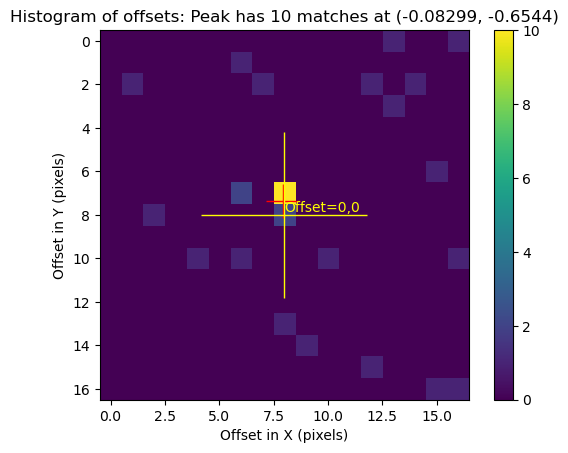

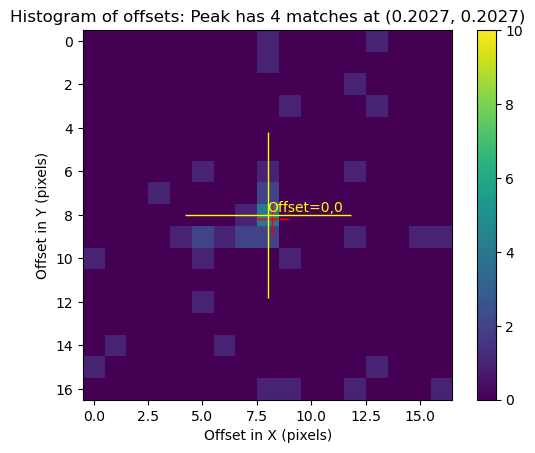

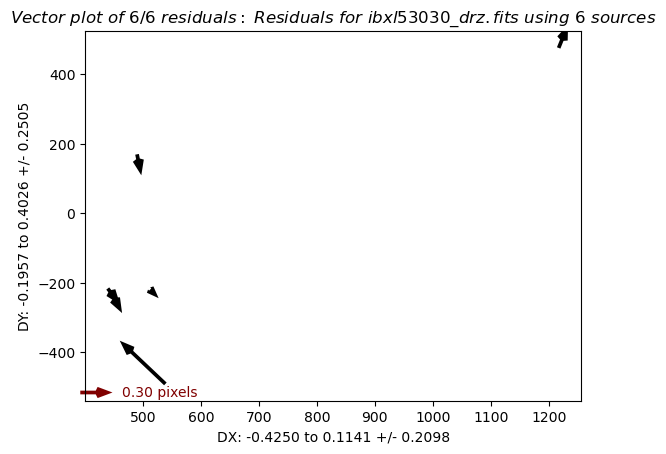

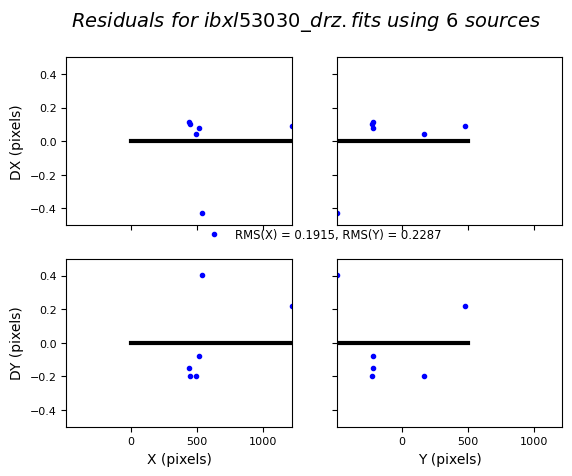

In [6]:
tweakreg.TweakReg('@drz.list', 
                  imagefindcfg={'threshold': 5, 'conv_width': 4.5, 'peakmin': 1}, 
                  minobj=5, 
                  shiftfile=True, 
                  expand_refcat=True, 
                  enforce_user_order=True, 
                  outshifts='shift4_drc.txt',
                  searchrad=1,
                  ylimit=0.5, 
                  tolerance=1,
                  nclip=1,
                  updatehdr=True,
                  interactive=False)

Tweakback is then run on the aligned DRZ files to propogate the updated WCS information back to the FLT files.

In [7]:
drz_files = glob.glob('i*0_drz.fits')

for f in drz_files:
    tb_input = f+'[sci,1]'
    hdu = fits.open(f)
    tweakback.apply_tweak(tb_input, orig_wcs_name=hdu[1].header['WCSNAME'])


*** 'apply_tweak' version 3.5.1 started at 09:50:05.967 (16/08/2023): ***

Using WCS with WCSNAME 'TWEAK' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl58sqq_flt.fits ...
  - Computed new WCS solution for ibxl58sqq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.214210575821  -2.4322813540517014
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.663745527183619e-05  7.760977353477646e-06
      CD2_1 CD2_2  : 8.568495067626945e-06  -3.2698707626116866e-05
      NAXIS : 1014  1014

* Working on input image ibxl58svq_flt.fits ...
  - Computed new WCS solution for ibxl58svq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.213755606884  -2.4303370564621867
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6633156103000046e-05  7.760386389603695e-06
      CD2_1 

  - Updated 'ibxl50cqq_flt.fits', extensions: 'sci',1

*** 'apply_tweak' version 3.5.1 started at 09:50:08.109 (16/08/2023): ***

Using WCS with WCSNAME 'TWEAK' (WCS key ' ') for 'tweaked_wcs_name'

* Setting 'output_wcs_name' to 'TWEAK'

* Working on input image ibxl53kxq_flt.fits ...
  - Computed new WCS solution for ibxl53kxq_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.288196507575  -2.4454106642899194
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.6458347591514066e-05  8.319617621300899e-06
      CD2_1 CD2_2  : 9.196105410461292e-06  -3.253720174668961e-05
      NAXIS : 1014  1014

* Working on input image ibxl53l9q_flt.fits ...
  - Computed new WCS solution for ibxl53l9q_flt.fits['sci',1]:
      WCS Keywords
      
      Number of WCS axes: 2
      CTYPE : 'RA---TAN-SIP'  'DEC--TAN-SIP'
      CRVAL : 85.287694870661  -2.4434734841152883
      CRPIX : 507.0  507.0
      CD1_1 CD1_2  : 3.64

## 3. Compare  `skymethod` options in AstroDrizzle

### `skymethod = 'localmin'`

When using AstroDrizzle to compute the sky in each frame, 'localmin' will compute a common sky for all members of an exposure, as described [here](https://drizzlepac.readthedocs.io/en/deployment/sky.html#drizzlepac.sky.sky). This algorithm is recommended when images are dominated by blank sky instead of extended, diffuse sources.

For a typical use, it will compute sky values for each chip/image extension (marked for sky subtraction in the input parameter) in an input image, and it will subtract the previously found minimum sky value from all chips in that image. This process is repeated for each input image.

In the command below, the aligned FLT frames are sky subtracted and drizzled together. Because the WFC3/IR data products are already cleaned of cosmic rays during calwf3 processing, cosmic-ray rejection is turned off in AstroDrizzle by setting the parameters `driz_separate`, `median`, `blot`, and `driz_cr` to 'False'.

In [8]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_localmin',
                                     preserve=False, 
                                     skymethod='localmin', 
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 09:50:08.7 (16/08/2023)


AstroDrizzle Version 3.5.1 started at: 09:50:08.7 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:17:34) [Clang 14.0.6 ]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.23.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.astrodrizzle:photutils Version -> 1.6.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  09:50:08.728 (16/08/2023)


==== Processing Step  Initialization  started at  09:50:08.728 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f160w_localmin_drz.fits
INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.000197334440930081
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01476776907997317
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01334701200947897
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01334571485020928
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.005004208754916356
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.00201443218106318
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.000670350933658959
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.006411463753624104
INFO:drizzl

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3347 pixels. 


*  Output image size:       3241 X 3347 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 09:50:12.287 (16/08/2023)


==== Processing Step Initialization finished at 09:50:12.287 (16/08/2023)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f160w_localmin
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  09:50:12.323 (16/08/2023)


==== Processing Step  Static Mask  started at  09:50:12.323 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.203442;   rms = 0.215411;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.780831;   rms = 0.196095;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00
INFO:drizzlepac.staticMask

==== Processing Step Static Mask finished at 09:50:12.830 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  09:50:12.831 (16/08/2023)


==== Processing Step  Subtract Sky  started at  09:50:12.831 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	localmin
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2023-08-16 09:50:13.196938


***** skymatch started on 2023-08-16 09:50:13.196938


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing sky values requested image extensions (detector chips):  -----


-----  Computing sky values requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.91085546523294 (brightness units)


   *   Image:   'ibxl50clq_flt.fits['SCI',1]'  --  SKY = 69.91085546523294 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1499   NEW MDRIZSKY = 1.1499


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1499   NEW MDRIZSKY = 1.1499


INFO:stsci.skypac.utils:   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.65751238430016 (brightness units)


   *   Image:   'ibxl50cqq_flt.fits['SCI',1]'  --  SKY = 70.65751238430016 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16218   NEW MDRIZSKY = 1.16218


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16218   NEW MDRIZSKY = 1.16218


INFO:stsci.skypac.utils:   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.3068482803795 (brightness units)


   *   Image:   'ibxl51eoq_flt.fits['SCI',1]'  --  SKY = 71.3068482803795 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17286   NEW MDRIZSKY = 1.17286


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.17286   NEW MDRIZSKY = 1.17286


INFO:stsci.skypac.utils:   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.11606921513449 (brightness units)


   *   Image:   'ibxl51etq_flt.fits['SCI',1]'  --  SKY = 71.11606921513449 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16972   NEW MDRIZSKY = 1.16972


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16972   NEW MDRIZSKY = 1.16972


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.69316563968679 (brightness units)


   *   Image:   'ibxl52k0q_flt.fits['SCI',1]'  --  SKY = 48.69316563968679 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.800908   NEW MDRIZSKY = 0.800908


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.800908   NEW MDRIZSKY = 0.800908


INFO:stsci.skypac.utils:   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.37878931010429 (brightness units)


   *   Image:   'ibxl52k5q_flt.fits['SCI',1]'  --  SKY = 48.37878931010429 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.06416387479608 (brightness units)


   *   Image:   'ibxl53kxq_flt.fits['SCI',1]'  --  SKY = 73.06416387479608 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20176   NEW MDRIZSKY = 1.20176


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.20176   NEW MDRIZSKY = 1.20176


INFO:stsci.skypac.utils:   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.91481476930849 (brightness units)


   *   Image:   'ibxl53l9q_flt.fits['SCI',1]'  --  SKY = 71.91481476930849 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18286   NEW MDRIZSKY = 1.18286


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.18286   NEW MDRIZSKY = 1.18286


INFO:stsci.skypac.utils:   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.07641024598125 (brightness units)


   *   Image:   'ibxl54bgq_flt.fits['SCI',1]'  --  SKY = 71.07641024598125 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16907   NEW MDRIZSKY = 1.16907


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16907   NEW MDRIZSKY = 1.16907


INFO:stsci.skypac.utils:   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.68095118295543 (brightness units)


   *   Image:   'ibxl54blq_flt.fits['SCI',1]'  --  SKY = 70.68095118295543 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16256   NEW MDRIZSKY = 1.16256


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.16256   NEW MDRIZSKY = 1.16256


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.16218253859437 (brightness units)


   *   Image:   'ibxl55f0q_flt.fits['SCI',1]'  --  SKY = 61.16218253859437 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.006   NEW MDRIZSKY = 1.006


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.006   NEW MDRIZSKY = 1.006


INFO:stsci.skypac.utils:   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.34678663276509 (brightness units)


   *   Image:   'ibxl55f5q_flt.fits['SCI',1]'  --  SKY = 61.34678663276509 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00904   NEW MDRIZSKY = 1.00904


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.00904   NEW MDRIZSKY = 1.00904


INFO:stsci.skypac.utils:   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.82008184840844 (brightness units)


   *   Image:   'ibxl56huq_flt.fits['SCI',1]'  --  SKY = 82.82008184840844 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36223   NEW MDRIZSKY = 1.36223


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36223   NEW MDRIZSKY = 1.36223


INFO:stsci.skypac.utils:   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.75536786164504 (brightness units)


   *   Image:   'ibxl56i2q_flt.fits['SCI',1]'  --  SKY = 82.75536786164504 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36117   NEW MDRIZSKY = 1.36117


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.36117   NEW MDRIZSKY = 1.36117


INFO:stsci.skypac.utils:   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.84120117422069 (brightness units)


   *   Image:   'ibxl57adq_flt.fits['SCI',1]'  --  SKY = 68.84120117422069 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1323   NEW MDRIZSKY = 1.1323


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1323   NEW MDRIZSKY = 1.1323


INFO:stsci.skypac.utils:   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.03820126790981 (brightness units)


   *   Image:   'ibxl57aiq_flt.fits['SCI',1]'  --  SKY = 68.03820126790981 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1191   NEW MDRIZSKY = 1.1191


      - EXT = 'SCI',1   delta(MDRIZSKY) = 1.1191   NEW MDRIZSKY = 1.1191


INFO:stsci.skypac.utils:   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.91123561288987 (brightness units)


   *   Image:   'ibxl58sqq_flt.fits['SCI',1]'  --  SKY = 48.91123561288987 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.804495   NEW MDRIZSKY = 0.804495


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.804495   NEW MDRIZSKY = 0.804495


INFO:stsci.skypac.utils:   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.57829450818199 (brightness units)


   *   Image:   'ibxl58svq_flt.fits['SCI',1]'  --  SKY = 48.57829450818199 (brightness units)


INFO:stsci.skypac.utils:       Sky change (data units):


       Sky change (data units):


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799019   NEW MDRIZSKY = 0.799019


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.799019   NEW MDRIZSKY = 0.799019


INFO:stsci.skypac.utils:***** skymatch ended on 2023-08-16 09:50:14.642767


***** skymatch ended on 2023-08-16 09:50:14.642767


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.445829


TOTAL RUN TIME: 0:00:01.445829


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 09:50:15.012 (16/08/2023)


==== Processing Step Subtract Sky finished at 09:50:15.012 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  09:50:15.013 (16/08/2023)


==== Processing Step  Separate Drizzle  started at  09:50:15.013 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 09:50:15.017 (16/08/2023)


==== Processing Step Separate Drizzle finished at 09:50:15.017 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  09:50:15.019 (16/08/2023)


==== Processing Step  Create Median  started at  09:50:15.019 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  09:50:15.023 (16/08/2023)


==== Processing Step  Blot  started at  09:50:15.023 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step Blot finished at 09:50:15.026 (16/08/2023)


==== Processing Step Blot finished at 09:50:15.026 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  09:50:15.028 (16/08/2023)


==== Processing Step  Driz_CR  started at  09:50:15.028 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  09:50:15.031 (16/08/2023)


==== Processing Step  Final Drizzle  started at  09:50:15.031 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	64
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INF

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 1.149898 to ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 1.162179 to ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51e

INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 1.119097 to ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.804495 to ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:driz

-Generating simple FITS output: f160w_localmin_drz_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_sci.fits


Writing out image to disk: f160w_localmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_wht.fits


Writing out image to disk: f160w_localmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_localmin_drz_ctx.fits


Writing out image to disk: f160w_localmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 09:50:23.323 (16/08/2023)


==== Processing Step Final Drizzle finished at 09:50:23.323 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 09:50:23.326 (16/08/2023).


AstroDrizzle Version 3.5.1 is finished processing at 09:50:23.326 (16/08/2023).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.5588 sec.


         Initialization          3.5588 sec.


INFO:drizzlepac.util:            Static Mask          0.5067 sec.


            Static Mask          0.5067 sec.


INFO:drizzlepac.util:           Subtract Sky          2.1801 sec.


           Subtract Sky          2.1801 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0037 sec.


       Separate Drizzle          0.0037 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0031 sec.


                   Blot          0.0031 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          8.2925 sec.


          Final Drizzle          8.2925 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          14.5449 sec.


                  Total          14.5449 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'match'`

When `skymethod` is set to ‘match’, differences in sky values between images in common sky regions will be computed. Thus, sky values will be relative (delta) to the sky computed in one of the input images whose sky value will be set to and reported as 0. This setting “equalizes” sky values between the images in large mosaics. 

This is the **recommended** setting for images containing diffuse sources (e.g., galaxies, nebulae) covering significant parts of the image.

In [9]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_match',
                                     preserve=False, 
                                     skymethod='match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 09:50:23.448 (16/08/2023)


AstroDrizzle Version 3.5.1 started at: 09:50:23.448 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:17:34) [Clang 14.0.6 ]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.23.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.astrodrizzle:photutils Version -> 1.6.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  09:50:23.455 (16/08/2023)


==== Processing Step  Initialization  started at  09:50:23.455 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f160w_match_drz.fits
INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.149898171424866
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.162179231643677
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.1728595495224
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.169721603393555
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8009082674980164
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7957373857498169
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.201763987541199
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.182859420776367
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.169069290161133
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.162564754486084
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.005999445915222
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.00903582572937
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 1.362229943275452
INFO:drizzlepac.i

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3347 pixels. 


*  Output image size:       3241 X 3347 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 09:50:26.885 (16/08/2023)


==== Processing Step Initialization finished at 09:50:26.885 (16/08/2023)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f160w_match
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  09:50:26.907 (16/08/2023)


==== Processing Step  Static Mask  started at  09:50:26.907 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.203442;   rms = 0.215411;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.780831;   rms = 0.196095;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00
INFO:drizzlepac.staticMask

==== Processing Step Static Mask finished at 09:50:27.385 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  09:50:27.387 (16/08/2023)


==== Processing Step  Subtract Sky  started at  09:50:27.387 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2023-08-16 09:50:27.845123


***** skymatch started on 2023-08-16 09:50:27.845123


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.81493 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.81493 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0298521


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0298521


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.58203 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.58203 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260214


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260214


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53847 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53847 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0417529


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0417529


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.87188 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.87188 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307888


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307888


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.03536 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.03536 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0334777


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0334777


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.31642 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.31642 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0216526


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0216526


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.6812 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.6812 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0441005


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0441005


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.43727 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.43727 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0236402


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0236402


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.4606 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.4606 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024024


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024024


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14355 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14355 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0188091


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0188091


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.03929 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.03929 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0170944


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0170944


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.05596 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.05596 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0173685


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0173685


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.63787 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.63787 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0269398


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0269398


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.3507 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.3507 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0222164


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0222164


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.424 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.424 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00697398


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00697398


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.371869 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.371869 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00611653


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00611653


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.0941533 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.0941533 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154864


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154864


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2023-08-16 09:50:49.033390


***** skymatch ended on 2023-08-16 09:50:49.033390


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:21.188267


TOTAL RUN TIME: 0:00:21.188267


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 09:50:49.411 (16/08/2023)


==== Processing Step Subtract Sky finished at 09:50:49.411 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  09:50:49.413 (16/08/2023)


==== Processing Step  Separate Drizzle  started at  09:50:49.413 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 09:50:49.418 (16/08/2023)


==== Processing Step Separate Drizzle finished at 09:50:49.418 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  09:50:49.420 (16/08/2023)


==== Processing Step  Create Median  started at  09:50:49.420 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  09:50:49.424 (16/08/2023)


==== Processing Step  Blot  started at  09:50:49.424 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step Blot finished at 09:50:49.428 (16/08/2023)


==== Processing Step Blot finished at 09:50:49.428 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  09:50:49.43 (16/08/2023)


==== Processing Step  Driz_CR  started at  09:50:49.43 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  09:50:49.435 (16/08/2023)


==== Processing Step  Final Drizzle  started at  09:50:49.435 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	64
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INF

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.029852 to ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.026021 to ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51e

INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.006117 to ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.001549 to ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:driz

-Generating simple FITS output: f160w_match_drz_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_sci.fits


Writing out image to disk: f160w_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_wht.fits


Writing out image to disk: f160w_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_match_drz_ctx.fits


Writing out image to disk: f160w_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 09:50:57.536 (16/08/2023)


==== Processing Step Final Drizzle finished at 09:50:57.536 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 09:50:57.53 (16/08/2023).


AstroDrizzle Version 3.5.1 is finished processing at 09:50:57.53 (16/08/2023).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.4292 sec.


         Initialization          3.4292 sec.


INFO:drizzlepac.util:            Static Mask          0.4787 sec.


            Static Mask          0.4787 sec.


INFO:drizzlepac.util:           Subtract Sky          22.0244 sec.


           Subtract Sky          22.0244 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0048 sec.


       Separate Drizzle          0.0048 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0037 sec.


                   Blot          0.0037 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          8.1011 sec.


          Final Drizzle          8.1011 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          34.0419 sec.


                  Total          34.0419 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin+match'`

When `skymethod` is set to ‘globalmin+match', AstroDrizzle will first find a minimum “global” sky value in all input images and then use the ‘match’ method to equalize sky values between images.

In [10]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin_match',
                                     preserve=False, 
                                     skymethod='globalmin+match',
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 09:50:57.677 (16/08/2023)


AstroDrizzle Version 3.5.1 started at: 09:50:57.677 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:17:34) [Clang 14.0.6 ]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.23.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.astrodrizzle:photutils Version -> 1.6.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  09:50:57.687 (16/08/2023)


==== Processing Step  Initialization  started at  09:50:57.687 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_match_drz.fits
INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02985210840794375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02602137716622471
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0417528736803978
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.03078882478515311
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.03347765459701662
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02165255951605154
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.04410053514825436
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02364022832305218
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.02402403247886189
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01880912778093064
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.01709438769519699
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0173685049302566
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.0269398372

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3347 pixels. 


*  Output image size:       3241 X 3347 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 09:51:01.211 (16/08/2023)


==== Processing Step Initialization finished at 09:51:01.211 (16/08/2023)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin_match
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  09:51:01.222 (16/08/2023)


==== Processing Step  Static Mask  started at  09:51:01.222 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.203442;   rms = 0.215411;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.780831;   rms = 0.196095;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00
INFO:drizzlepac.staticMask

==== Processing Step Static Mask finished at 09:51:01.730 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  09:51:01.732 (16/08/2023)


==== Processing Step  Subtract Sky  started at  09:51:01.732 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin+match
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2023-08-16 09:51:02.203018


***** skymatch started on 2023-08-16 09:51:02.203018


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing differences in sky values in overlapping regions:  -----


-----  Computing differences in sky values in overlapping regions:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.81493 [brightness units]


   *   Image 'ibxl50clq_flt.fits['SCI',1]' SKY = 1.81493 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0298521


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0298521


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.58203 [brightness units]


   *   Image 'ibxl50cqq_flt.fits['SCI',1]' SKY = 1.58203 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260214


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0260214


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53847 [brightness units]


   *   Image 'ibxl51eoq_flt.fits['SCI',1]' SKY = 2.53847 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0417529


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0417529


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.87188 [brightness units]


   *   Image 'ibxl51etq_flt.fits['SCI',1]' SKY = 1.87188 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307888


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0307888


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.03536 [brightness units]


   *   Image 'ibxl52k0q_flt.fits['SCI',1]' SKY = 2.03536 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0334777


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0334777


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.31642 [brightness units]


   *   Image 'ibxl52k5q_flt.fits['SCI',1]' SKY = 1.31642 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0216526


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0216526


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.6812 [brightness units]


   *   Image 'ibxl53kxq_flt.fits['SCI',1]' SKY = 2.6812 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0441005


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0441005


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.43727 [brightness units]


   *   Image 'ibxl53l9q_flt.fits['SCI',1]' SKY = 1.43727 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0236402


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0236402


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.4606 [brightness units]


   *   Image 'ibxl54bgq_flt.fits['SCI',1]' SKY = 1.4606 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024024


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.024024


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14355 [brightness units]


   *   Image 'ibxl54blq_flt.fits['SCI',1]' SKY = 1.14355 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0188091


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0188091


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.03929 [brightness units]


   *   Image 'ibxl55f0q_flt.fits['SCI',1]' SKY = 1.03929 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0170944


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0170944


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.05596 [brightness units]


   *   Image 'ibxl55f5q_flt.fits['SCI',1]' SKY = 1.05596 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0173685


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0173685


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.63787 [brightness units]


   *   Image 'ibxl56huq_flt.fits['SCI',1]' SKY = 1.63787 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0269398


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0269398


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.3507 [brightness units]


   *   Image 'ibxl56i2q_flt.fits['SCI',1]' SKY = 1.3507 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0222164


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.0222164


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.424 [brightness units]


   *   Image 'ibxl57adq_flt.fits['SCI',1]' SKY = 0.424 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00697398


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00697398


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.371869 [brightness units]


   *   Image 'ibxl57aiq_flt.fits['SCI',1]' SKY = 0.371869 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00611653


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00611653


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.0941533 [brightness units]


   *   Image 'ibxl58sqq_flt.fits['SCI',1]' SKY = 0.0941533 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154864


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0.00154864


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


   *   Image 'ibxl58svq_flt.fits['SCI',1]' SKY = 0 [brightness units]


INFO:stsci.skypac.utils:       Updating sky of image extension(s) [data units]:


       Updating sky of image extension(s) [data units]:


INFO:stsci.skypac.utils:       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


       -  EXT = 'SCI',1   delta(MDRIZSKY) = 0


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   "Global" sky value: 46.657810223000716 (brightness units)


   "Global" sky value: 46.657810223000716 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Final (match+global) sky [image units] for:


    Final (match+global) sky [image units] for:


INFO:stsci.skypac.utils:    # ibxl50clq_flt.fits['SCI',1]:   0.7972827213089435


    # ibxl50clq_flt.fits['SCI',1]:   0.7972827213089435


INFO:stsci.skypac.utils:    # ibxl50cqq_flt.fits['SCI',1]:   0.7934519900672244


    # ibxl50cqq_flt.fits['SCI',1]:   0.7934519900672244


INFO:stsci.skypac.utils:    # ibxl51eoq_flt.fits['SCI',1]:   0.8091834865813976


    # ibxl51eoq_flt.fits['SCI',1]:   0.8091834865813976


INFO:stsci.skypac.utils:    # ibxl51etq_flt.fits['SCI',1]:   0.7982194376861529


    # ibxl51etq_flt.fits['SCI',1]:   0.7982194376861529


INFO:stsci.skypac.utils:    # ibxl52k0q_flt.fits['SCI',1]:   0.8009082674980164


    # ibxl52k0q_flt.fits['SCI',1]:   0.8009082674980164


INFO:stsci.skypac.utils:    # ibxl52k5q_flt.fits['SCI',1]:   0.7890831724170513


    # ibxl52k5q_flt.fits['SCI',1]:   0.7890831724170513


INFO:stsci.skypac.utils:    # ibxl53kxq_flt.fits['SCI',1]:   0.8115311480492542


    # ibxl53kxq_flt.fits['SCI',1]:   0.8115311480492542


INFO:stsci.skypac.utils:    # ibxl53l9q_flt.fits['SCI',1]:   0.7910708412240519


    # ibxl53l9q_flt.fits['SCI',1]:   0.7910708412240519


INFO:stsci.skypac.utils:    # ibxl54bgq_flt.fits['SCI',1]:   0.7914546453798617


    # ibxl54bgq_flt.fits['SCI',1]:   0.7914546453798617


INFO:stsci.skypac.utils:    # ibxl54blq_flt.fits['SCI',1]:   0.7862397406819305


    # ibxl54blq_flt.fits['SCI',1]:   0.7862397406819305


INFO:stsci.skypac.utils:    # ibxl55f0q_flt.fits['SCI',1]:   0.7845250005961968


    # ibxl55f0q_flt.fits['SCI',1]:   0.7845250005961968


INFO:stsci.skypac.utils:    # ibxl55f5q_flt.fits['SCI',1]:   0.7847991178312564


    # ibxl55f5q_flt.fits['SCI',1]:   0.7847991178312564


INFO:stsci.skypac.utils:    # ibxl56huq_flt.fits['SCI',1]:   0.7943704501692113


    # ibxl56huq_flt.fits['SCI',1]:   0.7943704501692113


INFO:stsci.skypac.utils:    # ibxl56i2q_flt.fits['SCI',1]:   0.7896469726947983


    # ibxl56i2q_flt.fits['SCI',1]:   0.7896469726947983


INFO:stsci.skypac.utils:    # ibxl57adq_flt.fits['SCI',1]:   0.7744045940328175


    # ibxl57adq_flt.fits['SCI',1]:   0.7744045940328175


INFO:stsci.skypac.utils:    # ibxl57aiq_flt.fits['SCI',1]:   0.7735471418455729


    # ibxl57aiq_flt.fits['SCI',1]:   0.7735471418455729


INFO:stsci.skypac.utils:    # ibxl58sqq_flt.fits['SCI',1]:   0.7689792522247259


    # ibxl58sqq_flt.fits['SCI',1]:   0.7689792522247259


INFO:stsci.skypac.utils:    # ibxl58svq_flt.fits['SCI',1]:   0.7674306129009998


    # ibxl58svq_flt.fits['SCI',1]:   0.7674306129009998


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:***** skymatch ended on 2023-08-16 09:51:23.304278


***** skymatch ended on 2023-08-16 09:51:23.304278


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:21.101260


TOTAL RUN TIME: 0:00:21.101260


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 09:51:23.660 (16/08/2023)


==== Processing Step Subtract Sky finished at 09:51:23.660 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  09:51:23.661 (16/08/2023)


==== Processing Step  Separate Drizzle  started at  09:51:23.661 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 09:51:23.667 (16/08/2023)


==== Processing Step Separate Drizzle finished at 09:51:23.667 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  09:51:23.668 (16/08/2023)


==== Processing Step  Create Median  started at  09:51:23.668 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  09:51:23.673 (16/08/2023)


==== Processing Step  Blot  started at  09:51:23.673 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step Blot finished at 09:51:23.6 (16/08/2023)


==== Processing Step Blot finished at 09:51:23.6 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  09:51:23.678 (16/08/2023)


==== Processing Step  Driz_CR  started at  09:51:23.678 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  09:51:23.682 (16/08/2023)


==== Processing Step  Final Drizzle  started at  09:51:23.682 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	64
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INF

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.797283 to ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.793452 to ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51e

INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.773547 to ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.768979 to ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:driz

-Generating simple FITS output: f160w_globalmin_match_drz_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_sci.fits


Writing out image to disk: f160w_globalmin_match_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_wht.fits


Writing out image to disk: f160w_globalmin_match_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


Writing out image to disk: f160w_globalmin_match_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 09:51:31.738 (16/08/2023)


==== Processing Step Final Drizzle finished at 09:51:31.738 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 09:51:31.741 (16/08/2023).


AstroDrizzle Version 3.5.1 is finished processing at 09:51:31.741 (16/08/2023).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.5240 sec.


         Initialization          3.5240 sec.


INFO:drizzlepac.util:            Static Mask          0.5086 sec.


            Static Mask          0.5086 sec.


INFO:drizzlepac.util:           Subtract Sky          21.9278 sec.


           Subtract Sky          21.9278 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0054 sec.


       Separate Drizzle          0.0054 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0035 sec.


                   Blot          0.0035 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          8.0558 sec.


          Final Drizzle          8.0558 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          34.0251 sec.


                  Total          34.0251 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


### `skymethod = 'globalmin'`

When `skymethod` is set to ‘globalmin’, a common sky value will be computed for all exposures. AstroDrizzle will compute sky values for each chip/image extension, find the minimum sky value from all the exposures, and then subtract that minimum sky value from all chips in all images. 

This method may be useful when input images already have matched background values.

In [11]:
drizzlepac.astrodrizzle.AstroDrizzle('*flt.fits', 
                                     output='f160w_globalmin',     
                                     preserve=False,
                                     skymethod='globalmin',     
                                     driz_separate=False, 
                                     median=False, 
                                     blot=False, 
                                     driz_cr=False, 
                                     final_bits='64',
                                     final_wcs=True, 
                                     final_rot=257.)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle log file: astrodrizzle.log


AstroDrizzle log file: astrodrizzle.log


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 started at: 09:51:31.888 (16/08/2023)


AstroDrizzle Version 3.5.1 started at: 09:51:31.888 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:17:34) [Clang 14.0.6 ]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.23.4 
INFO:drizzlepac.astrodrizzle:astropy Version -> 5.2.1 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.7.2 
INFO:drizzlepac.astrodrizzle:photutils Version -> 1.6.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  09:51:31.895 (16/08/2023)


==== Processing Step  Initialization  started at  09:51:31.895 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: f160w_globalmin_drz.fits
INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:# “minmed” is highly recommended for three images,                           #


# “minmed” is highly recommended for three images,                           #


INFO:drizzlepac.processInput:#  and is good for four to six images,                                       #


#  and is good for four to six images,                                       #


INFO:drizzlepac.processInput:#  but should be avoided for ten or more images.                             #


#  but should be avoided for ten or more images.                             #


INFO:drizzlepac.processInput:#                                                                            #


#                                                                            #


INFO:drizzlepac.processInput:##############################################################################


##############################################################################


INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7972827213089435
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7934519900672244
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8091834865813976
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7982194376861529
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8009082674980164
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7890831724170513
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.8115311480492542
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7910708412240519
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7914546453798617
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7862397406819305
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7845250005961968
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7847991178312564
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 0.7943704501692113
INF

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 131 Mb.


*  Estimated memory usage:  up to 131 Mb.


INFO:drizzlepac.processInput:*  Output image size:       3241 X 3347 pixels. 


*  Output image size:       3241 X 3347 pixels. 


INFO:drizzlepac.processInput:*  Output image file:       ~ 124 Mb. 


*  Output image file:       ~ 124 Mb. 


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.util:==== Processing Step Initialization finished at 09:51:35.328 (16/08/2023)


==== Processing Step Initialization finished at 09:51:35.328 (16/08/2023)


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	*flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	f160w_globalmin
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	rules_file :	
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  09:51:35.340 (16/08/2023)


==== Processing Step  Static Mask  started at  09:51:35.340 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.203442;   rms = 0.215411;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.205314;   rms = 0.193961;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.217778;   rms = 0.205590;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  1.210815;   rms = 0.198140;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.780831;   rms = 0.196095;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode =  0.762465;   rms = 0.203042;   static_sig = 4.00
INFO:drizzlepac.staticMask

==== Processing Step Static Mask finished at 09:51:35.828 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  09:51:35.829 (16/08/2023)


==== Processing Step  Subtract Sky  started at  09:51:35.829 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	globalmin
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2023-08-16 09:51:36.209716


***** skymatch started on 2023-08-16 09:51:36.209716


INFO:stsci.skypac.utils:      Version 1.0.9


      Version 1.0.9


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).


'skymatch' task will apply computed sky differences to input image file(s).


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).


INFO:stsci.skypac.utils:'MDRIZSKY' header keyword will represent sky value *computed* from data.


'MDRIZSKY' header keyword will represent sky value *computed* from data.


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  User specified keywords:  -----


-----  User specified keywords:  -----


INFO:stsci.skypac.utils:       Sky Value Keyword:  'MDRIZSKY'


       Sky Value Keyword:  'MDRIZSKY'


INFO:stsci.skypac.utils:       Data Units Keyword: 'BUNIT'


       Data Units Keyword: 'BUNIT'


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Input file list:  -----


-----  Input file list:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50clq_flt.fits'


   **  Input image: 'ibxl50clq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50clq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl50cqq_flt.fits'


   **  Input image: 'ibxl50cqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl50cqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51eoq_flt.fits'


   **  Input image: 'ibxl51eoq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51eoq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl51etq_flt.fits'


   **  Input image: 'ibxl51etq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl51etq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k0q_flt.fits'


   **  Input image: 'ibxl52k0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl52k5q_flt.fits'


   **  Input image: 'ibxl52k5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl52k5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53kxq_flt.fits'


   **  Input image: 'ibxl53kxq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53kxq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl53l9q_flt.fits'


   **  Input image: 'ibxl53l9q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl53l9q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54bgq_flt.fits'


   **  Input image: 'ibxl54bgq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54bgq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl54blq_flt.fits'


   **  Input image: 'ibxl54blq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl54blq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f0q_flt.fits'


   **  Input image: 'ibxl55f0q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f0q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl55f5q_flt.fits'


   **  Input image: 'ibxl55f5q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl55f5q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56huq_flt.fits'


   **  Input image: 'ibxl56huq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56huq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl56i2q_flt.fits'


   **  Input image: 'ibxl56i2q_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl56i2q_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57adq_flt.fits'


   **  Input image: 'ibxl57adq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57adq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl57aiq_flt.fits'


   **  Input image: 'ibxl57aiq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl57aiq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58sqq_flt.fits'


   **  Input image: 'ibxl58sqq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58sqq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   **  Input image: 'ibxl58svq_flt.fits'


   **  Input image: 'ibxl58svq_flt.fits'


INFO:stsci.skypac.utils:       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


       EXT: 'SCI',1;	MASK: ibxl58svq_skymatch_mask_sci1.fits[0]


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Sky statistics parameters:  -----


-----  Sky statistics parameters:  -----


INFO:stsci.skypac.utils:       statistics function: 'median'


       statistics function: 'median'


INFO:stsci.skypac.utils:       lower = None


       lower = None


INFO:stsci.skypac.utils:       upper = None


       upper = None


INFO:stsci.skypac.utils:       nclip = 5


       nclip = 5


INFO:stsci.skypac.utils:       lsigma = 4.0


       lsigma = 4.0


INFO:stsci.skypac.utils:       usigma = 4.0


       usigma = 4.0


INFO:stsci.skypac.utils:       binwidth = 0.1


       binwidth = 0.1


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Data->Brightness conversion parameters for input files:  -----


-----  Data->Brightness conversion parameters for input files:  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50clq_flt.fits


   *   Image: ibxl50clq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl50cqq_flt.fits


   *   Image: ibxl50cqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51eoq_flt.fits


   *   Image: ibxl51eoq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl51etq_flt.fits


   *   Image: ibxl51etq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k0q_flt.fits


   *   Image: ibxl52k0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl52k5q_flt.fits


   *   Image: ibxl52k5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53kxq_flt.fits


   *   Image: ibxl53kxq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl53l9q_flt.fits


   *   Image: ibxl53l9q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54bgq_flt.fits


   *   Image: ibxl54bgq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl54blq_flt.fits


   *   Image: ibxl54blq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f0q_flt.fits


   *   Image: ibxl55f0q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl55f5q_flt.fits


   *   Image: ibxl55f5q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56huq_flt.fits


   *   Image: ibxl56huq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl56i2q_flt.fits


   *   Image: ibxl56i2q_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57adq_flt.fits


   *   Image: ibxl57adq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl57aiq_flt.fits


   *   Image: ibxl57aiq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58sqq_flt.fits


   *   Image: ibxl58sqq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:   *   Image: ibxl58svq_flt.fits


   *   Image: ibxl58svq_flt.fits


INFO:stsci.skypac.utils:       EXT = 'SCI',1


       EXT = 'SCI',1


INFO:stsci.skypac.utils:             Data units type: COUNT-RATE


             Data units type: COUNT-RATE


INFO:stsci.skypac.utils:             Conversion factor (data->brightness):  60.797431635711504


             Conversion factor (data->brightness):  60.797431635711504


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:-----  Computing "global" sky on requested image extensions (detector chips):  -----


-----  Computing "global" sky on requested image extensions (detector chips):  -----


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    "Global" sky value: 48.37878931010429 (brightness units)


    "Global" sky value: 48.37878931010429 (brightness units)


INFO:stsci.skypac.utils:


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50clq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl50cqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51eoq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl51etq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl52k5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53kxq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl53l9q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54bgq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl54blq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f0q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl55f5q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56huq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl56i2q_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57adq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl57aiq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58sqq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


    Computed sky change (data units) for image ibxl58svq_flt.fits['SCI',1]:


INFO:stsci.skypac.utils:      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


      - EXT = 'SCI',1   delta(MDRIZSKY) = 0.795737   NEW MDRIZSKY = 0.795737


INFO:stsci.skypac.utils:***** skymatch ended on 2023-08-16 09:51:37.629971


***** skymatch ended on 2023-08-16 09:51:37.629971


INFO:stsci.skypac.utils:TOTAL RUN TIME: 0:00:01.420255


TOTAL RUN TIME: 0:00:01.420255


INFO:drizzlepac.util:==== Processing Step Subtract Sky finished at 09:51:37.991 (16/08/2023)


==== Processing Step Subtract Sky finished at 09:51:37.991 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  09:51:37.993 (16/08/2023)


==== Processing Step  Separate Drizzle  started at  09:51:37.993 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step Separate Drizzle finished at 09:51:37.997 (16/08/2023)


==== Processing Step Separate Drizzle finished at 09:51:37.997 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  09:51:37.999 (16/08/2023)


==== Processing Step  Create Median  started at  09:51:37.999 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  09:51:38.003 (16/08/2023)


==== Processing Step  Blot  started at  09:51:38.003 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step Blot finished at 09:51:38.006 (16/08/2023)


==== Processing Step Blot finished at 09:51:38.006 (16/08/2023)


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  09:51:38.007 (16/08/2023)


==== Processing Step  Driz_CR  started at  09:51:38.007 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  09:51:38.010 (16/08/2023)


==== Processing Step  Final Drizzle  started at  09:51:38.010 (16/08/2023)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'build': False, 'stepsize': 10, 'coeffs': True, 'wcskey': '', 'wht_type': 'EXP', 'kernel': 'square', 'wt_scl': 'exptime', 'pixfrac': 1.0, 'fillval': None, 'maskval': None, 'bits': 64, 'units': 'cps'}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	64
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	logfile :	astrodrizzle.log
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	rules_file :	None
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INF

WCS Keywords


INFO:astropy.wcs.wcs:


INFO:astropy.wcs.wcs:Number of WCS axes: 2


Number of WCS axes: 2


INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'  


CTYPE : 'RA---TAN'  'DEC--TAN'  


INFO:astropy.wcs.wcs:CRVAL : 85.25357180057523  -2.451810429483568  


CRVAL : 85.25357180057523  -2.451810429483568  


INFO:astropy.wcs.wcs:CRPIX : 1620.3563102319183  1674.2407014329049  


CRPIX : 1620.3563102319183  1674.2407014329049  


INFO:astropy.wcs.wcs:CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


CD1_1 CD1_2  : 8.013881489775232e-06  -3.471193433233374e-05  


INFO:astropy.wcs.wcs:CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


CD2_1 CD2_2  : -3.4711934332333745e-05  -8.01388148977523e-06  


INFO:astropy.wcs.wcs:NAXIS : 3241  3347


NAXIS : 3241  3347


INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl50clq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50clq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl50cqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl50cqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl51e

INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl57aiq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl57aiq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:drizzlepac.cdriz:-Drizzling using kernel = square

INFO:drizzlepac.adrizzle:-Drizzle input: ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.adrizzle:Applying sky value of 0.795737 to ibxl58sqq_flt.fits[sci,1]
INFO:drizzlepac.imageObject:Applying EXPTIME weighting to DQ mask for chip 1
INFO:drizzlepac.adrizzle:Writing out mask file: ibxl58sqq_sci1_final_mask.fits
INFO:drizzlepac.adrizzle:Using WCSLIB-based coordinate transformation...
INFO:drizzlepac.adrizzle:stepsize = 10
INFO:driz

-Generating simple FITS output: f160w_globalmin_drz_sci.fits


  warnings.warn(

INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_sci.fits


Writing out image to disk: f160w_globalmin_drz_sci.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_wht.fits


Writing out image to disk: f160w_globalmin_drz_wht.fits


INFO:drizzlepac.outputimage:Writing out image to disk: f160w_globalmin_drz_ctx.fits


Writing out image to disk: f160w_globalmin_drz_ctx.fits


INFO:drizzlepac.util:==== Processing Step Final Drizzle finished at 09:51:45.931 (16/08/2023)


==== Processing Step Final Drizzle finished at 09:51:45.931 (16/08/2023)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 3.5.1 is finished processing at 09:51:45.933 (16/08/2023).


AstroDrizzle Version 3.5.1 is finished processing at 09:51:45.933 (16/08/2023).


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          3.4330 sec.


         Initialization          3.4330 sec.


INFO:drizzlepac.util:            Static Mask          0.4881 sec.


            Static Mask          0.4881 sec.


INFO:drizzlepac.util:           Subtract Sky          2.1619 sec.


           Subtract Sky          2.1619 sec.


INFO:drizzlepac.util:       Separate Drizzle          0.0041 sec.


       Separate Drizzle          0.0041 sec.


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:                   Blot          0.0029 sec.


                   Blot          0.0029 sec.


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:          Final Drizzle          7.9206 sec.


          Final Drizzle          7.9206 sec.


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:                  Total          14.0106 sec.


                  Total          14.0106 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


## 4. Compare the MDRIZSKY values for each method

Below we provide a gif comparing the upper portion of the final drizzled image. We cycle through three of the versions that use different `skymethod` algorithms:  

![SegmentLocal](labeled_local_globalmatch_match.gif)

Below is the code used to compare results from the various skymatching methods. It's best practice to use more compact for loops when possible in situations like this, but we wanted to write out each file to ensure we are gathering the proper `MDRIZSKY` values for each `skymethod` run. We also display a table (Pandas DataFrame) of the different sky matching `MDRIZSKY` values for comparison.

In [12]:
# This is a quick method of opening our different results and gathering the `MDRIZSKY` values: 
im = fits.open("f160w_globalmin_drz_sci.fits")
rootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
mdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_globalmin_match_drz_sci.fits")
globalmatchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
globalmatchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_match_drz_sci.fits")
matchrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
matchmdrizsky = im[1].data['MDRIZSKY']
im.close()

im = fits.open("f160w_localmin_drz_sci.fits")
localrootname = im[1].data['ROOTNAME']
asn_id = im[1].data['ASN_ID']
orientat = im[1].data['ORIENTAT']
localmdrizsky = im[1].data['MDRIZSKY']
im.close()

mdrizsky_val = pd.DataFrame(
    {'Rootname': rootname,
     'globalmin': mdrizsky,
     'globalmin_match': globalmatchmdrizsky,
     'match': matchmdrizsky,
     'local': localmdrizsky})

mdrizsky_val

,Rootname,globalmin,globalmin_match,match,local
0,ibxl50clq,0.795737,0.797283,0.029852,1.149898
1,ibxl50cqq,0.795737,0.793452,0.026021,1.162179
2,ibxl51eoq,0.795737,0.809183,0.041753,1.172860
3,ibxl51etq,0.795737,0.798219,0.030789,1.169722
4,ibxl52k0q,0.795737,0.800908,0.033478,0.800908
5,ibxl52k5q,0.795737,0.789083,0.021653,0.795737
6,ibxl53kxq,0.795737,0.811531,0.044101,1.201764
7,ibxl53l9q,0.795737,0.791071,0.023640,1.182859
8,ibxl54bgq,0.795737,0.791455,0.024024,1.169069
9,ibxl54blq,0.795737,0.786240,0.018809,1.162565


These computed sky values can be visualized in the plot below. To reiterate, the MDRIZSKY keyword reports the value subtracted from each image, and not the sky level itself. Thus the values for `skymethod='match'` are close to zero. We also note that varying background levels across the individual tiles result in inaccurate sky background determination when `skymethod='match'` and thus a mismatched sky in the final mosaic.

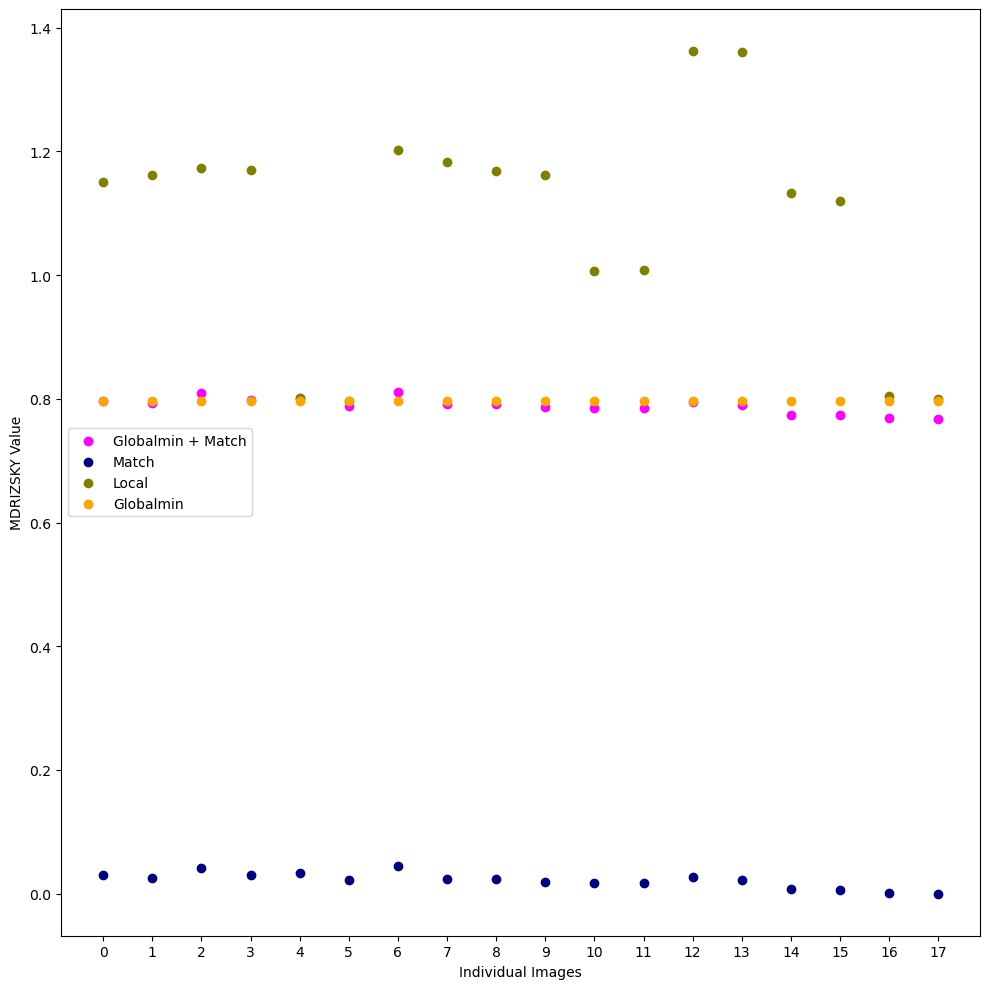

In [13]:
index = mdrizsky_val.index.tolist()
globalmin = list(mdrizsky_val['globalmin'])
globalmin_match = list(mdrizsky_val['globalmin_match'])
match = list(mdrizsky_val['match'])
local = list(mdrizsky_val['local'])

# Plotting code: 
fig = plt.figure(figsize=[10, 10])
plt.scatter(index, globalmin_match, color='magenta', label='Globalmin + Match')
plt.scatter(index, match, color='navy', label='Match')
plt.scatter(index, local, color='olive', label='Local')
plt.scatter(index, globalmin, color='orange', label='Globalmin')
plt.xlabel('Individual Images')
plt.ylabel('MDRIZSKY Value')
plt.legend(loc="center left")
plt.xticks(index)
plt.tight_layout()
plt.show()

## 5. Display the full 'matched' mosaic 

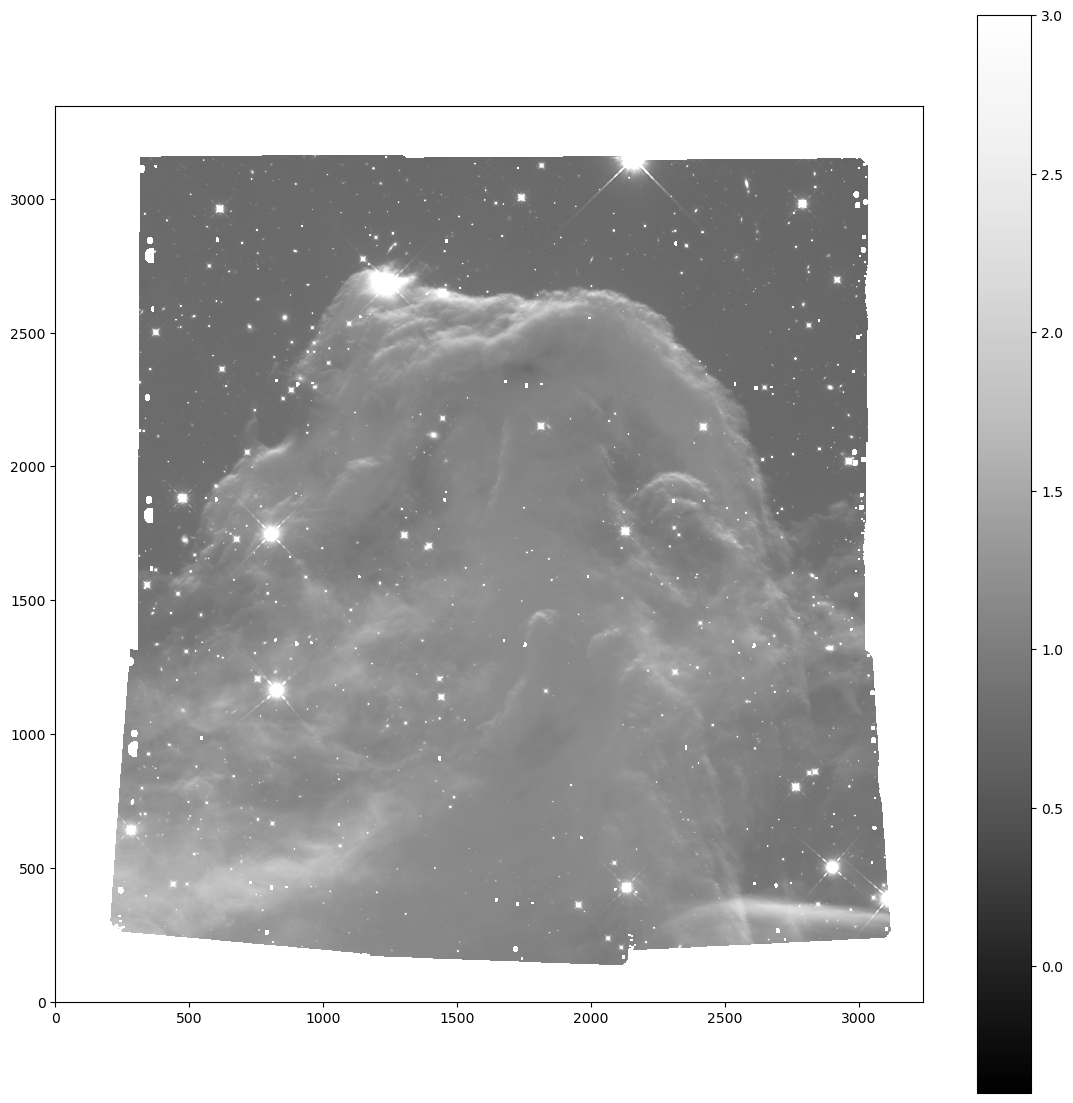

In [14]:
sci = fits.getdata('f160w_match_drz_sci.fits')
fig = plt.figure(figsize=(14, 14))
plt.imshow(sci, vmin=-0.4, vmax=3, cmap='Greys_r', origin='lower')
plt.colorbar()
plt.show()

# About this Notebook

    Author: C. Martlin & K.Huynh, STScI WFC3 Team
    Updated: August 10, 2023
    